# GEO 352P Final Project - National Park Visitors and Biodiversity

### Tianyi Xu 11/4/2022

### Introduction and Motivation

<img src="https://i0.wp.com/www.anseladams.com/wp-content/uploads/2021/07/50101253.jpg?w=800&ssl=1" alt="Yosemite Valley, Thunderstorm by Ansel Adams" width="490" style="float: left" />
<p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p>

I am a paleobiologist studying reptile biodiversity change through time and in response to global change phenomena, and I am also a national park enthusiast. Growing up, I love explore nature and I always get excited by the splendid wildlife and ecosystems. I especially love the US National Parks, and would go on roadtrips to visit these parks on almost every vacation. 

Here's a brief history of the US National Parks. The first national park, Yellowstone, was established in Montana and Wyoming as a public park for visitors in 1872. Later in 1916, President Woodrow Wilson started the National Park Service, which was responsible for protecting the 35 national parks and monuments then managed by the department. As of 2022, there are 63 national parks protected by the National Park Service across 30 states and two US territories. With scenic drives, wildlife and flora, hiking trails, historic sites, these national parks are enjoyed by countless domestic and international visitors every year who seek for amazing adventures in natural wonders, including me.

In this project, I am interested in investigating visitation patterns over time and biodiversity of the national parks. I created maps for national park location and biodiversity, made data visualization for visitor increase and species information, and explored correlation between national park visitor numbers and biodiversity.

Hope you enjoy reading it!

Picture: Yosemite Valley, Thunderstorm by Ansel Adams

Source: https://www.anseladams.com/thunderstorm-yosemite-valley/

### Methods

#### Packages

For this project, I am using `numpy` and `pandas` for data cleaning and analysis, and `matplotlib`, `seaborn`, `plotly`, and `cartopy` for making figures.

In [1]:
# Import packages
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset as netcdf_dataset
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.crs as ccrs
import warnings
warnings.filterwarnings("ignore") 
import cartopy.io.img_tiles as cimgt
import seaborn as sns
from matplotlib.colors import ListedColormap
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
pio.renderers.default = "notebook"

#### Color Palette

For all the figures produced in this project, I am using a color palette inspired from Acadia National Park, one of my favorite national parks! This palette is also colorblind-friendly. For larger barplots, I am using the seaborn palete `magma`.

Source: https://github.com/kevinsblake/NatParksPalettes

<img src="https://raw.githubusercontent.com/kevinsblake/NatParksPalettes/main/photos/Acadia.png" alt="Yosemite Valley, Thunderstorm by Ansel Adams" width="490" style="float: left" />

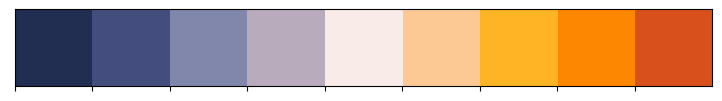

In [2]:
# Create a palette using hex values
acadia = ['#212e51','#434e7e', '#8087aa', '#b7abbc', '#f9ece8', '#fcc893', '#feb424', '#fd8700', '#d8511c']
acadia7 = ['#212e51','#434e7e', '#8087aa', '#b7abbc', '#f9ece8', '#fcc893', '#feb424']
sns.palplot(sns.color_palette(acadia))

#### Data

Datasets used in this project are publicly available on Kaggle and Data World.

Sources: 
* https://www.kaggle.com/datasets/aliamini587/biodiversity-in-national-parks
* https://data.world/inform8n/us-national-parks-visitation-1904-2016-with-boundaries

In [3]:
# Import datasets
parks = pd.read_csv('parks.csv')
species = pd.read_csv('species.csv')
visit = pd.read_csv('allvisit.csv')

# Extract only information of interest and cleaning data
visit = visit[visit['Unit Type'] == "National Park"]
visit = visit.rename(columns = {'Unit Name': 'Park'})
visit = visit[['Region', 'State', 'Unit Code', 'Park', 'Visitors', 'YearRaw']]
visit.drop(visit.loc[visit['Park'] == "Denali National Preserve"].index, inplace = True)

`Parks` is a dataset with park names, sizes, and geographic locations.

In [4]:
parks = parks.rename(columns = {'Park Name': 'Park'})
parks.head(3)

Park Code                    Park State   Acres  Latitude  Longitude
0      ACAD    Acadia National Park    ME   47390     44.35     -68.21
1      ARCH    Arches National Park    UT   76519     38.68    -109.57
2      BADL  Badlands National Park    SD  242756     43.75    -102.50

In [5]:
# Change acres column to float type
parks['Acres'] = parks['Acres'].astype(float)/1000

In [6]:
size = parks['Acres']
size.dtype

dtype('float64')

`Species` is a dataset with park names and information of all species observations recorded in the parks.

In [7]:
species = species.rename(columns = {'Park Name': 'Park'})
species.head(3)

Species ID                  Park Category         Order    Family  \
0  ACAD-1000  Acadia National Park   Mammal  Artiodactyla  Cervidae   
1  ACAD-1001  Acadia National Park   Mammal  Artiodactyla  Cervidae   
2  ACAD-1002  Acadia National Park   Mammal     Carnivora   Canidae   

          Scientific Name                                       Common Names  \
0             Alces alces                                              Moose   
1  Odocoileus virginianus  Northern White-Tailed Deer, Virginia Deer, Whi...   
2           Canis latrans                             Coyote, Eastern Coyote   

  Record Status Occurrence  Nativeness Abundance Seasonality  \
0      Approved    Present      Native      Rare    Resident   
1      Approved    Present      Native  Abundant         NaN   
2      Approved    Present  Not Native    Common         NaN   

  Conservation Status  
0                 NaN  
1                 NaN  
2  Species of Concern

`Visit` is a dataset with park names and annual visitor counts from 1904 to 2016.

In [8]:
visit.head(3)

Region State Unit Code                       Park  Visitors YearRaw
0     PW    OR      CRLA  Crater Lake National Park    1500.0    1904
3     PW    WA      OLYM      Olympic National Park    2200.0    1935
5     NE    ME      ACAD       Acadia National Park   64000.0    1919

### Data Analysis and Visualization

#### Display National Park Distribution Using `Cartopy`

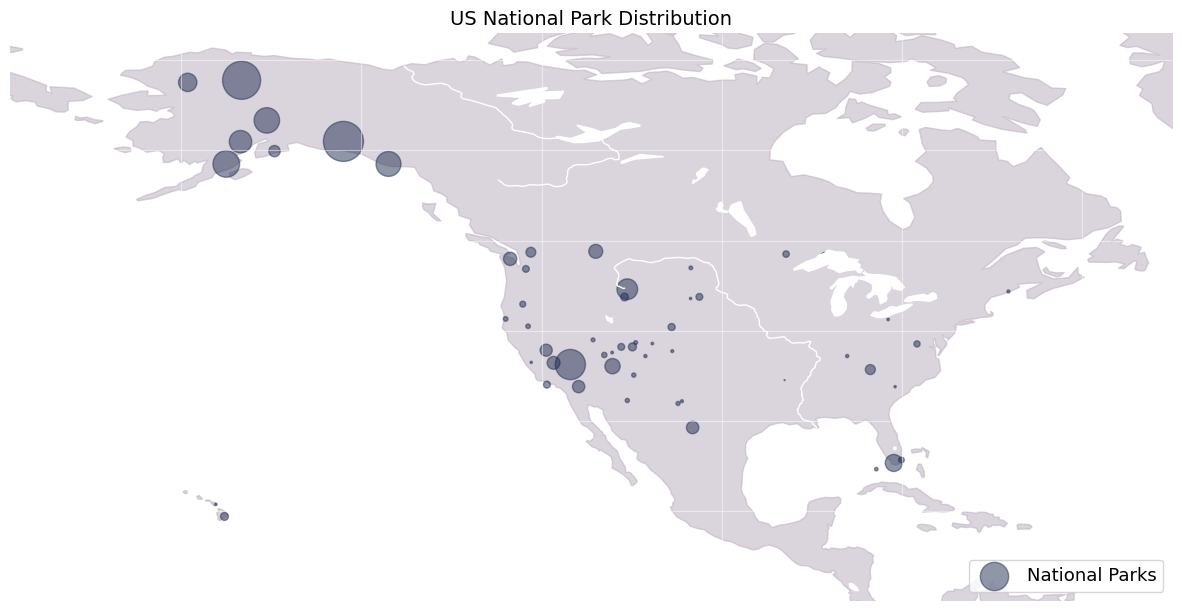

In [9]:
# Set up the figure and use platecarree projection
plt.figure(figsize = (15, 15))
ax = plt.axes(projection = ccrs.PlateCarree())

# Create and set extent for the map
extent = [-179, -50, 10, 55]
ax.set_extent(extent)

# Add features to the map
# ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAND, color = '#b7abbc', alpha = 0.5)
ax.add_feature(cartopy.feature.LAKES, color = 'white')
ax.add_feature(cartopy.feature.RIVERS, color = 'white')
ax.axis('off')

# Add gridlines
ax.gridlines(color = 'white', alpha = 0.5)

# You can also add stamen terrain background to the map
# stamen_terrain = cimgt.Stamen('terrain-background')
# ax.add_image(stamen_terrain, 4)

# Plot national park locations
plt.scatter(parks['Longitude'], parks['Latitude'], color = '#212e51', alpha = 0.5, s = size/10,
         transform = ccrs.PlateCarree(), label = 'National Parks')
plt.legend(loc = 'lower right', fontsize = 13)
plt.title("US National Park Distribution", fontsize = 14);

#### Time-series Analysis with National Park Visitors from 1904-2016 and Total Visitors

In [10]:
# Unique states
unistate = visit["State"].unique()
print(unistate)

['OR' 'WA' 'ME' 'TX' 'FL' 'NC' 'MI' 'CA' 'VA' 'CO' 'UT' 'NM' 'WY' 'HI'
 'KY' 'NV' 'ND' 'VI' 'AZ' 'SD' 'OH' 'SC' 'AR' 'AK' 'AS' 'MT' 'MN']


In [11]:
# Unique years
print(visit["YearRaw"].unique())
print(visit["YearRaw"].unique().shape)

['1904' '1935' '1919' '1944' '1948' '1931' '1940' '1971' '1936' '1934'
 '1929' '1937' '1924' '1921' '1906' '1908' '1963' '1965' '1972' '1960'
 '1938' '1941' '1923' '1957' '1915' '1933' '1917' '1939' '1978' '1985'
 '1920' '1922' '1982' '1956' '1970' '1932' '2002' '1911' '1976' 'Total'
 '2016' '2015' '2014' '2013' '2012' '2011' '2010' '2009' '2008' '2007'
 '2006' '2005' '2003' '2004' '2001' '2000' '1999' '1998' '1997' '1996'
 '1995' '1994' '1993' '1992' '1991' '1990' '1989' '1988' '1987' '1986'
 '1984' '1983' '1981' '1980' '1979' '1977' '1975' '1974' '1973' '1969'
 '1968' '1967' '1966' '1964' '1962' '1961' '1959' '1958' '1955' '1954'
 '1953' '1952' '1951' '1950' '1949' '1947' '1946' '1945' '1943' '1942'
 '1930' '1928' '1927' '1926' '1925' '1918' '1916' '1914' '1913' '1912'
 '1910' '1909' '1905' '1907']
(114,)


Notice that there is a value of total visitors of all years, which would make the analysis harder. Here, I made a new dataset just for total visitors of all national parks, and deleted rows with total visitors on the original dataset.

In [12]:
# Create a new dataset only with total visitors
totalvisit = visit[visit['YearRaw'] == 'Total']

# Sorting the dataset by visitor numbers
totalvisit.sort_values(by = ['Visitors'], ascending = False).head()

Region State Unit Code                                 Park     Visitors  \
412     SE    NC      GRSM  Great Smoky Mountains National Park  521947058.0   
652     IM    AZ      GRCA           Grand Canyon National Park  205486894.0   
708     PW    CA      YOSE               Yosemite National Park  190404561.0   
644     IM    CO      ROMO         Rocky Mountain National Park  180076609.0   
496     IM    WY      YELL            Yellowstone National Park  175040126.0   

    YearRaw  
412   Total  
652   Total  
708   Total  
644   Total  
496   Total

In [13]:
totalvisit.sort_values(by = ['Visitors']).head()

Region State Unit Code                               Park   Visitors  \
760     PW    AS      NPSA    National Park of American Samoa   113694.0   
743     AK    AK      KOVA         Kobuk Valley National Park   156655.0   
735     AK    AK      GAAR  Gates of the Arctic National Park   225813.0   
744     AK    AK      LACL           Lake Clark National Park   363894.0   
414     MW    MI      ISRO          Isle Royale National Park  1071614.0   

    YearRaw  
760   Total  
743   Total  
735   Total  
744   Total  
414   Total

Looks like the most visited national parks are Great Smoky, Grand Canyon, Yosemite, Rocky Mountain, and Yellowstone. Not surprising at all! I've been to 4/5. Maybe it's time for us to visit some less well-known national parks, such as parks in the Pacific Ocean and Alaska.

Below, I am plotting visitor counts in states with the most national parks: California, Alaska, and Utah.

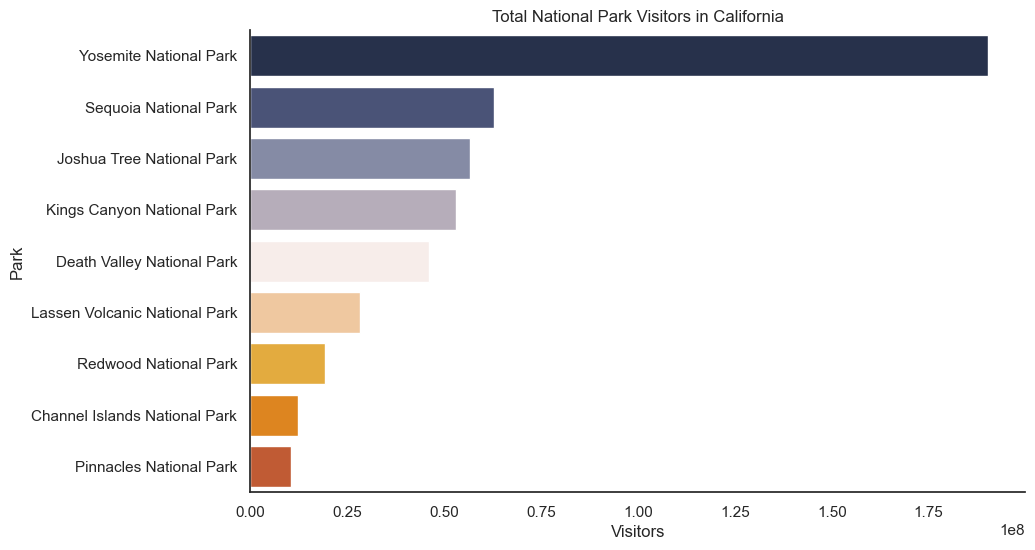

In [29]:
# National parks in California
ca = totalvisit[totalvisit['State'] == 'CA']

# Barplot
sns.set(font_scale = 1)
sns.set_style("white")
plt.figure(figsize = (10, 6))

sns.barplot(data = ca, x = "Visitors", y = "Park",
            palette = acadia, order = ca.sort_values('Visitors', ascending = False).Park).set(title = 'Total National Park Visitors in California')
sns.despine();

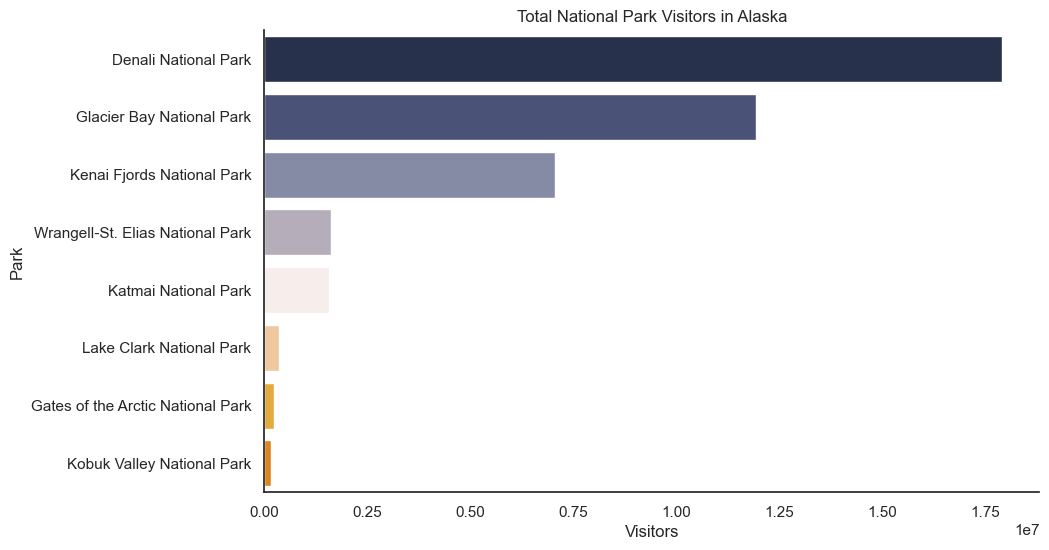

In [30]:
# National parks in Alaska
ak = totalvisit[totalvisit['State'] == 'AK']

# Barplot
sns.set(font_scale = 1)
sns.set_style("white")
plt.figure(figsize = (10, 6))

sns.barplot(data = ak, x = "Visitors", y = "Park",
            palette = acadia, order = ak.sort_values('Visitors', ascending = False).Park).set(title = 'Total National Park Visitors in Alaska')
sns.despine();

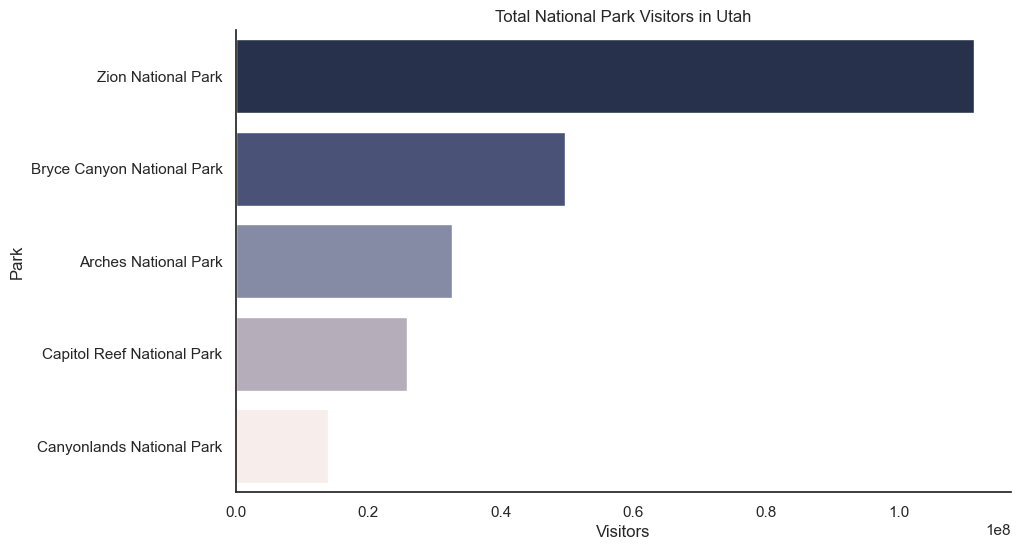

In [31]:
# National parks in Utah
ut = totalvisit[totalvisit['State'] == 'UT']

# Barplot
sns.set(font_scale = 1)
sns.set_style("white")
plt.figure(figsize = (10, 6))

sns.barplot(data = ut, x = "Visitors", y = "Park",
            palette = acadia, order = ut.sort_values('Visitors', ascending = False).Park).set(title = 'Total National Park Visitors in Utah')
sns.despine();

Which states have the most national park visitors? The answer is North Carolina, with the Great Smokies!

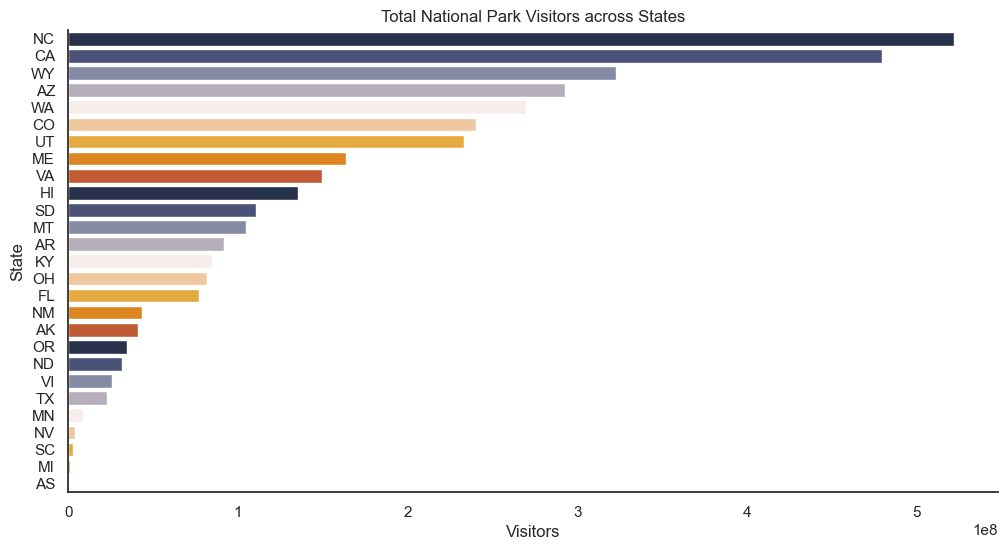

In [20]:
# Group national park visitors by state and sort the value
state = pd.DataFrame(totalvisit.groupby('State')['Visitors'].sum(), columns = ['Visitors'])
state = state.reset_index()
state.sort_values(by = ['Visitors'], ascending = False, inplace = True)

# Barplot
plt.figure(figsize = (12, 6))
sns.set(font_scale = 1)
sns.set_style("white")
sns.barplot(data = state, x = "Visitors", y = "State",
            palette = acadia, order = state.sort_values('Visitors', ascending = False).State).set(title = 'Total National Park Visitors across States')
sns.despine();

In [21]:
# Drop total visitor rows from the visitor dataset
visit.drop(visit.loc[visit['YearRaw'] == "Total"].index, inplace = True)
visit.sort_values(by = ['YearRaw'], inplace = True)
print(visit.shape)
visit.head()

(4587, 6)


Region State Unit Code                         Park  Visitors YearRaw
0       PW    OR      CRLA    Crater Lake National Park    1500.0    1904
345     MW    AR      HOSP    Hot Springs National Park  101000.0    1904
339     MW    SD      WICA      Wind Cave National Park    2900.0    1904
315     PW    WA      MORA  Mount Rainier National Park     563.0    1904
206     PW    CA      KICA   Kings Canyon National Park    1000.0    1904

After some further data cleaning, we are ready for plotting a time-series graph of national park visitors through time.

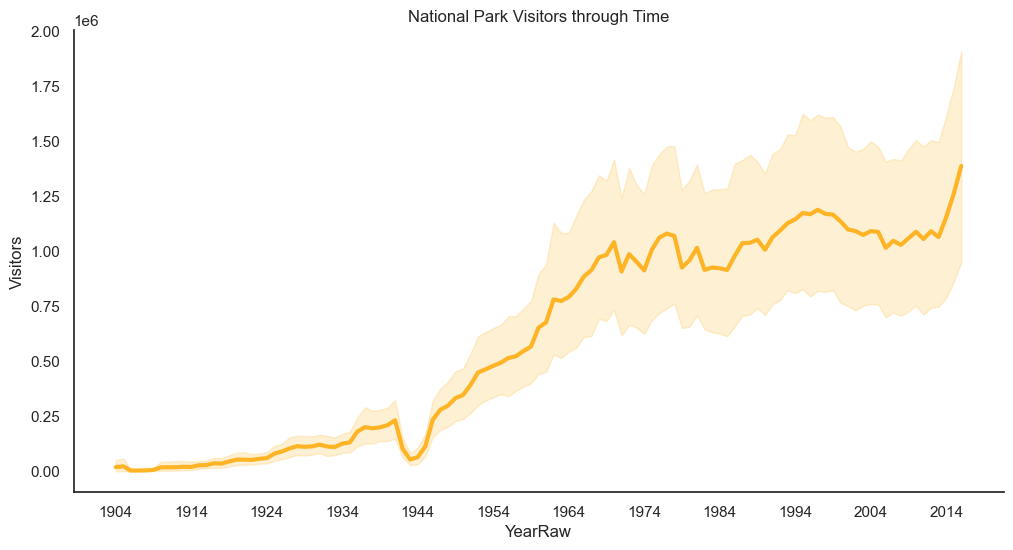

In [22]:
# Visitors through time of all national parks
plt.figure(figsize = (12, 6))
sns.set_style('white')
sns.lineplot(data = visit, x = 'YearRaw', y = 'Visitors', lw = 3, color = '#feb424').set(title = 'National Park Visitors through Time')
plt.xticks(np.arange(0, len(set(visit['YearRaw'])) + 1, 10))

sns.despine();

What about the increasing trend of national park visitors for individual state? Here, I used `plotly` to create an interactive plot.

In [23]:
# Group visitors by states and years for visualization
stateyear = pd.DataFrame(visit.groupby(['YearRaw', 'State'])['Visitors'].sum(), columns = ['Visitors'])
stateyear = stateyear.reset_index()
stateyear.head()

YearRaw State  Visitors
0    1904    AR  101000.0
1    1904    CA    1000.0
2    1904    OR    1500.0
3    1904    SD    2900.0
4    1904    WA     563.0

In [24]:
# Extract the magma palette from sns
pal = list(sns.color_palette(palette = 'magma', n_colors = 27).as_hex())

# Set up the template
pio.templates.default = "simple_white"
fig = go.Figure()

# Plotly graph
for state, color in zip(unistate, pal):
    fig.add_trace(go.Scatter(x = stateyear[stateyear['State'] == state]['YearRaw'],
                             y = stateyear[stateyear['State'] == state]['Visitors'],
                             name = state,
                             line_color = color, 
                             fill = None)) 
# Add layout
fig.update_layout(title = dict(text = "National Park Visitors through Time Across States"), 
                  xaxis = dict(title = "Year"), 
                  yaxis = dict(title = "Visitors"))

# Add two buttons: select and deselect all
fig.update_layout(dict(updatemenus = [dict(type = "buttons", direction = "left",
                                         buttons = list([dict(args = ["visible", "legendonly"], label = "Deselect All", method = "restyle"),
                                                       dict(args = ["visible", True], label = "Select All", method = "restyle")]),
                                         pad = {"r": 10, "t": 10},
                                         showactive = False, x = 1, xanchor = "right",
                                         y = 1.1, yanchor = "top")]))
fig.show()

Most of the national parks have an increasing number of visitors through time, but a minority of them have a relatively stable number.

#### National Park Biodiversity Analysis

What species are found in national parks across the US?

In [25]:
# Unique species category
print(species["Category"].unique())

['Mammal' 'Bird' 'Reptile' 'Amphibian' 'Fish' 'Vascular Plant'
 'Spider/Scorpion' 'Insect' 'Invertebrate' 'Fungi' 'Nonvascular Plant'
 'Crab/Lobster/Shrimp' 'Slug/Snail' 'Algae']


In [26]:
# Numbers of species for each category
species['Category'].value_counts()

Vascular Plant         65221
Bird                   14601
Insect                 14349
Fungi                   6203
Nonvascular Plant       4278
Fish                    3956
Mammal                  3867
Invertebrate            1566
Reptile                 1343
Algae                    976
Slug/Snail               787
Spider/Scorpion          776
Amphibian                743
Crab/Lobster/Shrimp      582
Name: Category, dtype: int64

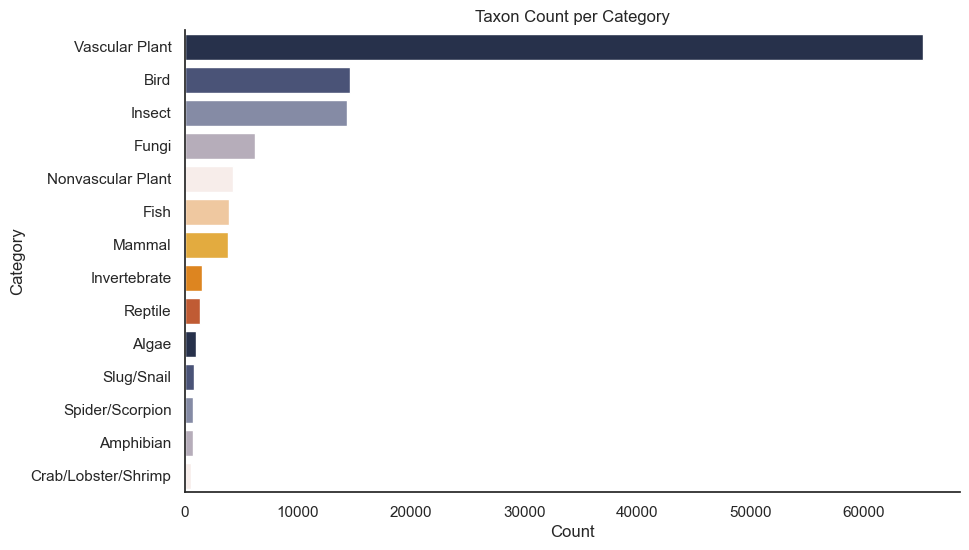

In [33]:
# Create a dataset with category counts
category = pd.DataFrame(species.groupby("Category").size(), columns = ["Count"])
category = category.reset_index()

# Plot taxon count for each category
sns.set(font_scale = 1)
sns.set_style("white")
plt.figure(figsize = (10, 6))

sns.barplot(data = category, x = "Count", y = "Category", 
            order = category.sort_values('Count', ascending = False).Category,
           palette = acadia).set(title = 'Taxon Count per Category')
sns.despine();

The majority of species found in national parks are vascular plant, which is not surprised at all! However, I am a vertebrate biologist.

In [34]:
# Select only vertebrates from the biodiversity data
vert = species[species['Category'].isin(['Bird','Fish', 'Mammal', 'Reptile', 'Amphibian'])]
# Species count in each category
vert_category = pd.DataFrame(vert.groupby("Category").size(), columns = ["Count"])
vert_category = vert_category.reset_index()
vert_category

Category  Count
0  Amphibian    743
1       Bird  14601
2       Fish   3956
3     Mammal   3867
4    Reptile   1343

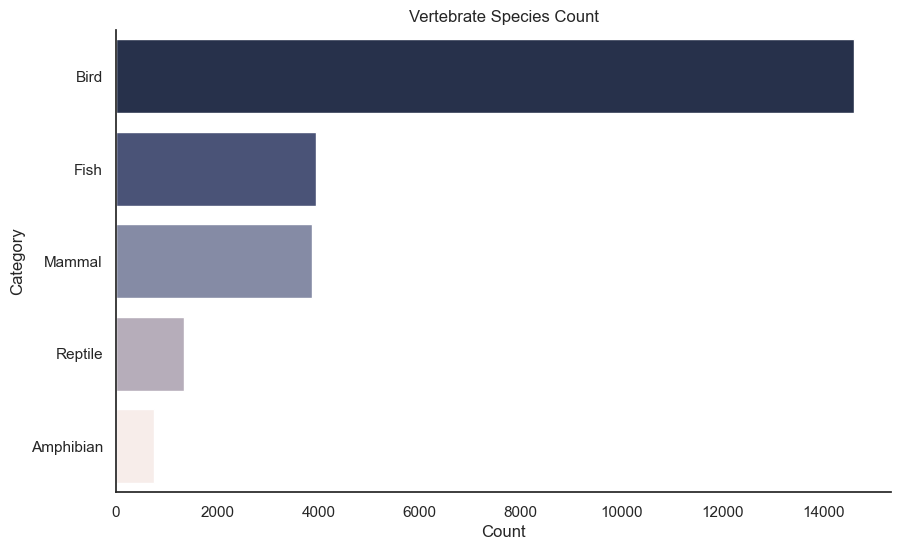

In [38]:
# Barplot with only vertebrate species count
sns.set(font_scale = 1)
sns.set_style("white")
plt.figure(figsize = (10, 6))

sns.barplot(data = vert_category, x = "Count", y = "Category",
           palette = acadia, 
           order = vert_category.sort_values('Count', ascending = False).Category).set(title = 'Vertebrate Species Count')
sns.despine();

There are a lot of birds, but not many herps. Let's only consider terrestrial vertebrates (non-fish vertebrates).

In [39]:
# Select non-fish vertebrates
nfvert = species[species['Category'].isin(['Bird', 'Mammal', 'Reptile', 'Amphibian'])]
nfvert_category = pd.DataFrame(nfvert.groupby("Category").size(), columns = ["Count"])
nfvert_category = nfvert_category.reset_index()
nfvert_category

Category  Count
0  Amphibian    743
1       Bird  14601
2     Mammal   3867
3    Reptile   1343

In [40]:
# Group and sort dataset by vertebrate biodiversity
nfvertdiversity = nfvert.groupby("Park")["Scientific Name"].count().reset_index(name = 'Count')
nfvertdiversity.sort_values(by = ['Count'], ascending = False).head()

Park  Count
14      Death Valley National Park    904
44           Redwood National Park    727
21      Grand Canyon National Park    653
3           Big Bend National Park    579
9   Carlsbad Caverns National Park    536

In [60]:
# Sort values by lowest count
nfvertdiversity.sort_values(by = ['Count']).head()

Park  Count
27                         Haleakala National Park     72
28                  Hawaii Volcanoes National Park    110
34                      Kobuk Valley National Park    164
18  Gates Of The Arctic National Park and Preserve    174
15               Denali National Park and Preserve    223

The top 5 national parks with highest non-fish vertebrate biodiversity are Death Valley, Redwood, Grand Canyon, Big Bend, and Carlsbad Caverns. 

In [41]:
# Add biodiversity data to the parks dataset for location information
parkdiversity = pd.merge(parks, nfvertdiversity)
parkdiversity.head(3)

Park Code                    Park State    Acres  Latitude  Longitude  Count
0      ACAD    Acadia National Park    ME   47.390     44.35     -68.21    445
1      ARCH    Arches National Park    UT   76.519     38.68    -109.57    292
2      BADL  Badlands National Park    SD  242.756     43.75    -102.50    326

With a merged dataset, we are able to plot vertebrate biodiversity data on the US map.

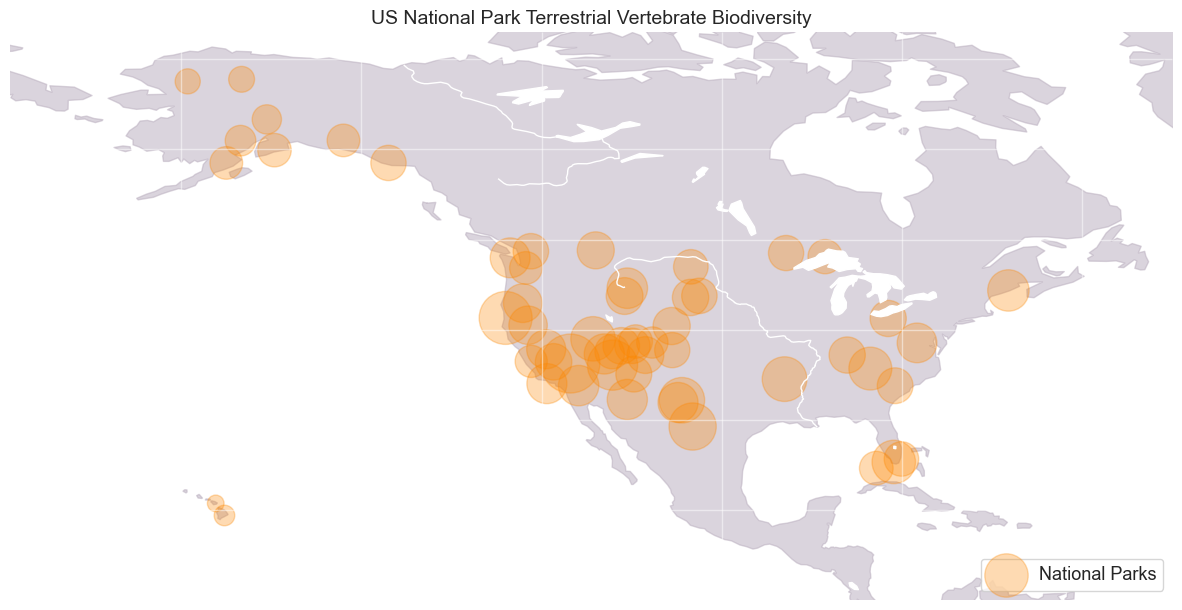

In [42]:
plt.figure(figsize = (15, 15))
ax = plt.axes(projection = ccrs.PlateCarree())

# Create and set extent for the map
extent = [-179, -50, 10, 55]
ax.set_extent(extent)

# Add features to the map
# ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAND, color = '#b7abbc', alpha = 0.5)
ax.add_feature(cartopy.feature.LAKES, color = 'white')
ax.add_feature(cartopy.feature.RIVERS, color = 'white')
ax.axis('off')

# Add gridlines
ax.gridlines(color = 'white', alpha = 0.5)

# Plot national park locations
plt.scatter(parks['Longitude'], parks['Latitude'], color = "#fd8700", alpha = 0.3, s = parkdiversity["Count"]*2,
         transform = ccrs.PlateCarree(), label = 'National Parks')
plt.legend(loc = 'lower right', fontsize = 13)
plt.title("US National Park Terrestrial Vertebrate Biodiversity", fontsize = 14);

What are the national parks with the most terrestrial vertebrate species of conservation concern?

In [43]:
# Count of conservation category in each park
conserve = nfvert[['Park', 'Conservation Status']].groupby(['Park', 'Conservation Status']).size()

# Convert to dataframe
conserve_df = conserve.to_frame().reset_index()
conserve_df.columns = ['Park', 'Conservation Status', 'Count']

<Figure size 1000x600 with 0 Axes>

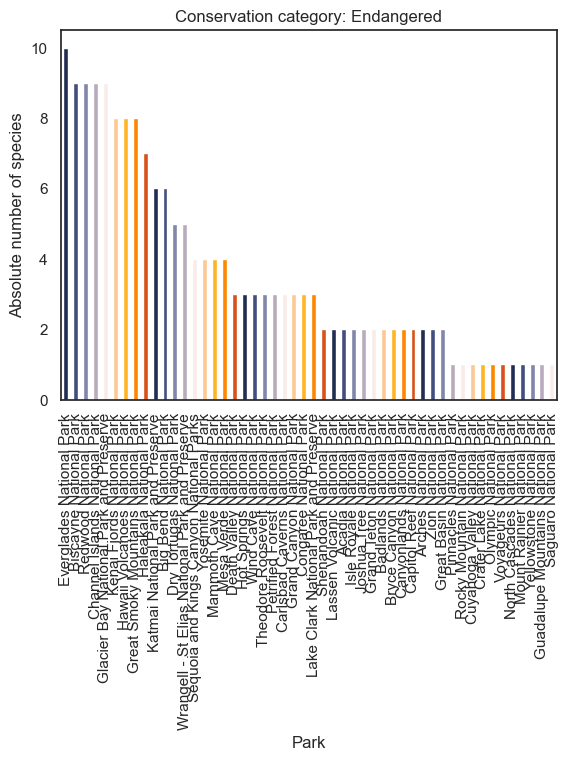

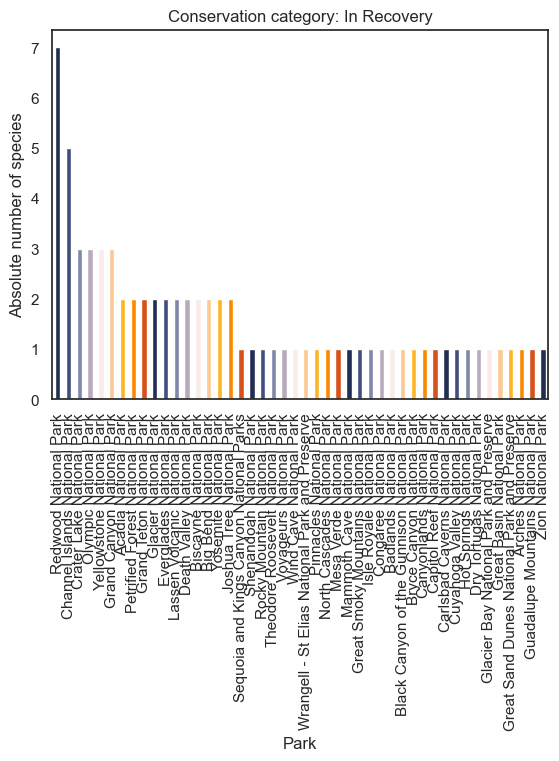

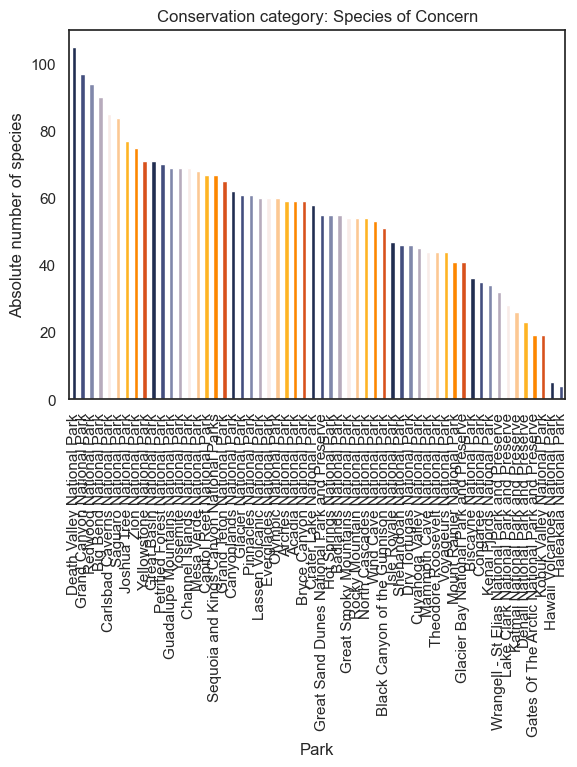

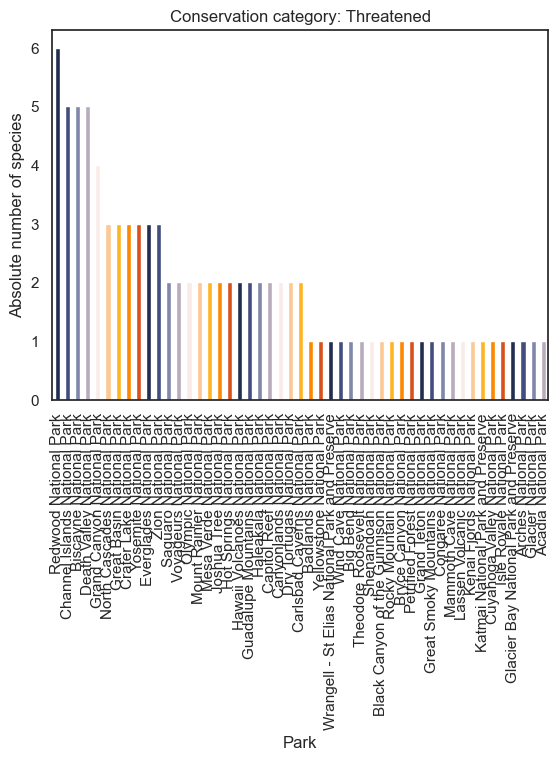

In [50]:
iucn = ['Endangered', 'In Recovery', 'Species of Concern', 'Threatened']
plt.figure(figsize = (10, 6))

# Use a for loop to create barplots for each conservation category
for i in iucn:
    subset = conserve_df[conserve_df['Conservation Status'] == i]
    subset.sort_values(by = 'Count', ascending = False).plot(x = 'Park', y = 'Count', kind = 'bar', legend = None, color = acadia)
    plt.ylabel('Absolute number of species')
    plt.title('Conservation category: %s' % (i))
plt.show();

Let's take a closer look at reptile species! (I study them :D)

In [52]:
# Select only reptile, and use groupby to see reptile diversity in each park
reptile = vert[species['Category'] == 'Reptile']
reptilediversity = reptile.groupby("Park")["Scientific Name"].count().reset_index(name = 'Count')
reptilediversity.sort_values(by = ['Count'], ascending = False).head()

Park  Count
14      Death Valley National Park     90
19      Grand Canyon National Park     76
3           Big Bend National Park     62
9   Carlsbad Caverns National Park     62
40           Saguaro National Park     62

The parks with the most reptile species are Death Valley, Grand Canyon, Big Bend, Carlsbad Caverns, and Saguaro. Very interesting! I have been to 3/5, and will visit Big Bend and Carlsbad Caverns this Thanksgiving.

In [53]:
# The most common reptiles found in the park
famreptile = reptile.groupby("Family")["Scientific Name"].count().reset_index(name = 'Count')
famreptile.sort_values(by = ['Count'], ascending = False).head()

Family  Count
7   Colubridae    559
15   Iguanidae    246
25   Viperidae     99
11    Emydidae     90
19   Scincidae     67

Which national parks have invasive reptile species?

In [54]:
# Select the non-native reptile species
invasive = reptile[reptile["Nativeness"] == "Not Native"]
invasivecount = invasive.groupby("Park")["Scientific Name"].count().reset_index(name = 'Count')
invasivecount.sort_values(by = ['Count'], ascending = False, inplace = True)

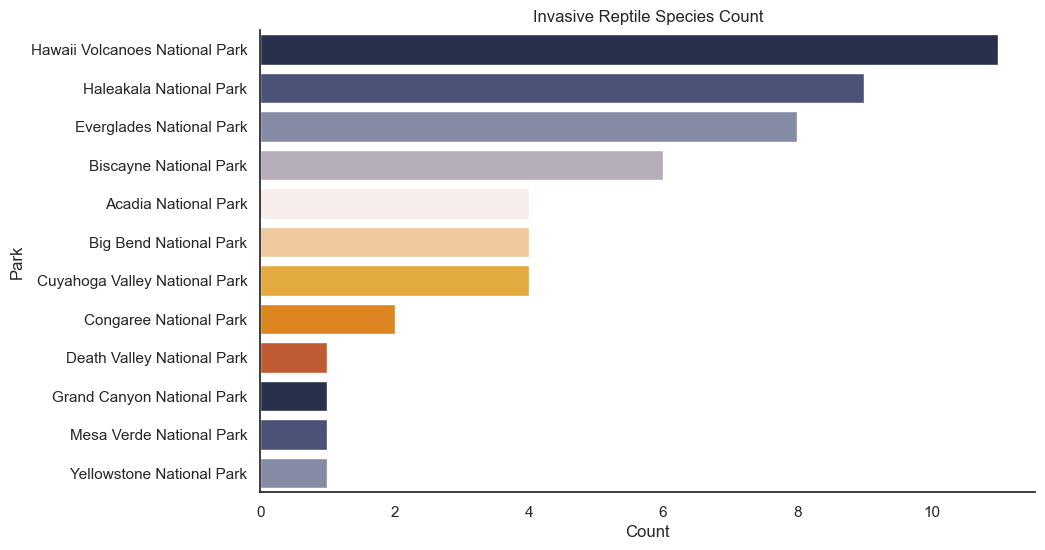

In [56]:
sns.set(font_scale = 1)
sns.set_style("white")
plt.figure(figsize = (10, 6))

# Barplot of invasive species of reptiles in each park
sns.barplot(data = invasivecount, x = "Count", y = "Park",
           palette = acadia).set(title = 'Invasive Reptile Species Count')
sns.despine();

According to this barplot, national parks in Hawaii and Florida have the most invasive reptile species.

#### Explore Correlations between Variables

In this section, I hope to answer three questions with existing data.

Are there correlations between:
* Terrestrial vertebrate species diversity and national park size?
* Visitor counts and national park size?
* Terrestrial vertebrate species diversity and visitor counts?

In [57]:
# Merge the biodiversity and total visit datasets
merge = pd.merge(parkdiversity, totalvisit, on = ['Park'])
merge.head()

Park Code                    Park State_x    Acres  Latitude  Longitude  \
0      ACAD    Acadia National Park      ME   47.390     44.35     -68.21   
1      ARCH    Arches National Park      UT   76.519     38.68    -109.57   
2      BADL  Badlands National Park      SD  242.756     43.75    -102.50   
3      BIBE  Big Bend National Park      TX  801.163     29.25    -103.25   
4      BISC  Biscayne National Park      FL  172.924     25.65     -80.08   

   Count Region State_y Unit Code     Visitors YearRaw  
0    445     NE      ME      ACAD  163512192.0   Total  
1    292     IM      UT      ARCH   32577956.0   Total  
2    326     MW      SD      BADL   69483454.0   Total  
3    579     IM      TX      BIBE   15820237.0   Total  
4    309     SE      FL      BISC   18615078.0   Total

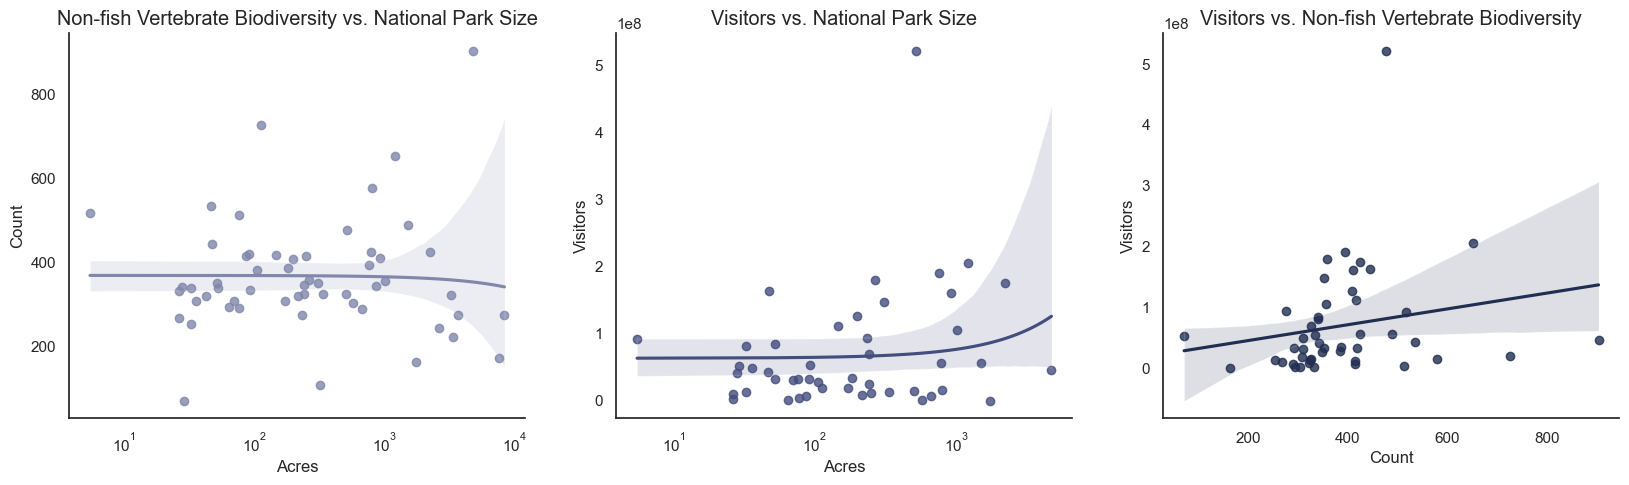

In [58]:
# Set a template for subplots
fig, axes = plt.subplots(1, 3, figsize = (20, 5))
sns.set(font_scale = 1.2)
sns.set_style("white")

# First plot: Biodiversity vs. Park Size
g = sns.regplot(ax = axes[0], x = "Acres", y = "Count", data = parkdiversity, color = "#8087aa")
g.set_title('Non-fish Vertebrate Biodiversity vs. National Park Size')
g.set(xscale = "log")

# Second plot: Visitors vs. Park Size
h = sns.regplot(ax = axes[1], x = "Acres", y = "Visitors", data = merge, color = "#434e7e")
h.set_title('Visitors vs. National Park Size')
h.set(xscale = "log")

# Third plot: Visitors vs. Biodiversity
j = sns.regplot(ax = axes[2], x = "Count", y = "Visitors", data = merge, color = "#212e51")
j.set_title('Visitors vs. Non-fish Vertebrate Biodiversity')

sns.despine();

According to the linear regression plots, there is no significant correlation between national park size and either biodiversity or visitor counts. This is probably because national park size varies to a great extent, and there are other factors playing a more important role in determining visitor counts and biodiversity. The number of visitors may be greatly impacted by parks' locations and reputation. Park biodiversity, on the other hand, may be related to climate and ecosystem in which the park is located. 

What is interesting is the positive correlation between visitor counts and terrestrial vertebrate biodiversity. As the park biodiversity increases, the park tends to be more visitors. This is expected because many visitors go to national parks for their abundance of unique wildlife and ecosystems, like myself!

### Future Directions

* Effect of COVID-19 on visitor numbers of national parks
* Addition of finer geographic data for national park shapes
* Interactive maps of biodiversity in national parks
* Correlation analyses between more variables of national parks, such as ecosystem types and numbers of microhabitats in parks vs. biodiversity or visitors 